In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Outline

1. Import Libraries
2. Initialize dataset and split into training and validation
3. Date preprocessing
4. Initialize model's architecture
5. Model training
6. Model Evaluation
7. Save the model's parameters



# Importing libraries

In [2]:
%%capture

! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torch import nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import requests
import math
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification
import random

# Initialize Dataset using ImageFolder class and Split into Training and Validation Sets

In [4]:
# Path where the data is stored
data_dir = Path('/content/drive/MyDrive/Projects/Brose_Vision_Transformer/images/images')

ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()

# Spliting the data into training and validation set
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])

val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

## Visualize the dataset with their labels

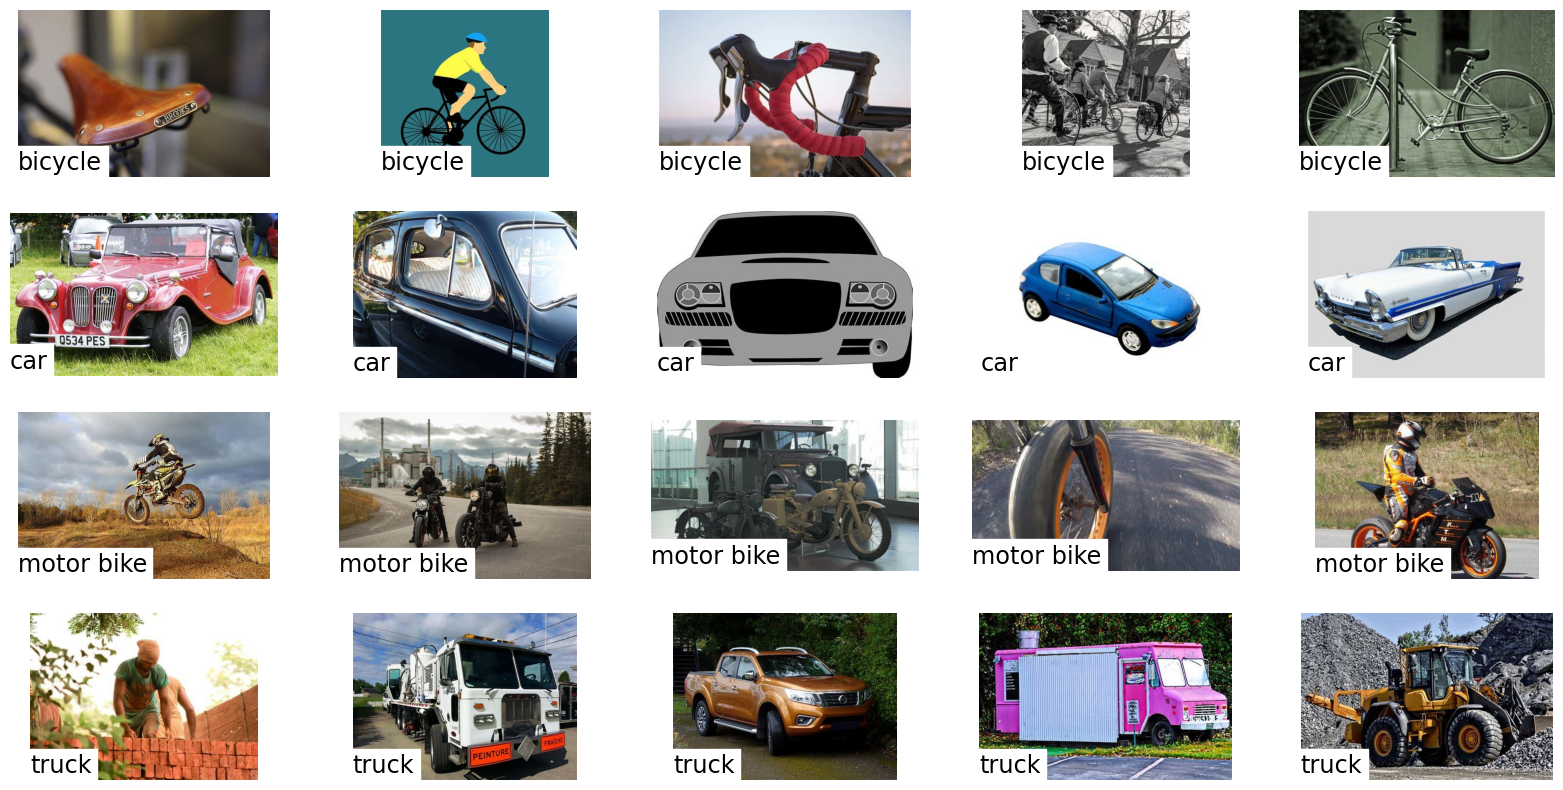

In [5]:

plt.figure(figsize=(20, 10))
num_examples_per_class = 5  # Number of random examples to show per class
i = 1

# Loop through each class in the dataset
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    #print(folder)
    image_paths = sorted(folder.glob('*'))

    # Filter to keep only the valid image extensions
    valid_image_paths = [path for path in image_paths if path.suffix in ds.extensions]

    # Randomly sample 'num_examples_per_class' images from the valid image paths
    sampled_images = random.sample(valid_image_paths, min(num_examples_per_class, len(valid_image_paths)))

    # Loop through the sampled images and display them
    for image_path in sampled_images:
        image = Image.open(image_path)  # Open the image
        plt.subplot(len(ds.classes), num_examples_per_class, i)  # Plot the image
        ax = plt.gca()

        # Set the title as the class name
        ax.set_title(
            class_name,
            size='xx-large',
            pad=5,
            loc='left',
            y=0,
            backgroundcolor='white'
        )
        ax.axis('off')  # Remove axis lines
        plt.imshow(image)  # Display the image
        i += 1  # Increment the subplot index


# Preparing Labels for Our Model's prediction

In [6]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [7]:
print(label2id)

{'bicycle': '0', 'car': '1', 'motor bike': '2', 'truck': '3'}


# Data Preprocessing : To apply transformation to images

## Image Classification Collator applies the pre-trained ViT feature extractor to the images. It prepares the images and labels for model input during batching.



In [8]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

# Init Feature Extractor, Model, Data Loaders

## Load a pre-trained Vision Transformer (ViT) feature extractor and model from HuggingFace

## ViT feature extractor (used to resize, normalize, etc. images before feeding them into the model)


In [9]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Pre-trained ViT model for image classification, fine-tuned for a specific number of classes
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)

# Dataloader for train and validation set
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Model Training

In [10]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [11]:
pl.seed_everything(42)

# Initialize the classifier module
classifier = Classifier(model, lr=2e-5)

# Set up PyTorch Lightning Trainer to use GPU, 16-bit precision, and run for 10 epochs
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=5)

# Start training the model
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params | Mode 
--------------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M | eval 
1 | val_acc | MulticlassAccuracy        | 0      | train
------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# Evaluation - Check if it Worked 😅

In [12]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([1, 1, 0, 0, 3, 3, 2, 2])
Labels: tensor([1, 1, 0, 0, 3, 3, 2, 2])


# Function to predict only a single image

In [11]:
def predict_image(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB format
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Move the inputs and model to the GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted label
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    predicted_label = model.config.id2label[str(predicted_class_idx)]

    # Visualize the image with the predicted label
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f'Predicted Label: {predicted_label}', size=20, pad=20)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

    return predicted_label

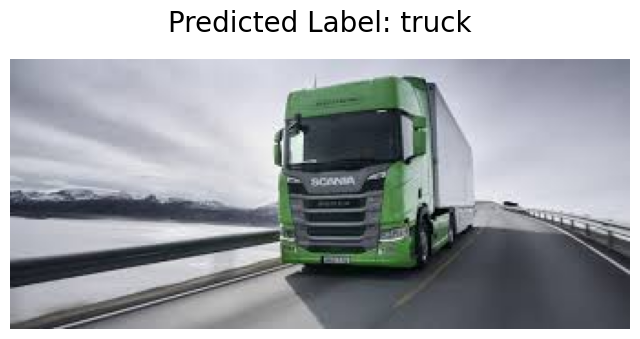

Predicted Label: truck


In [17]:
image_path = "/content/drive/MyDrive/Projects/Brose_Vision_Transformer/images/test_images/test_4.jpg"
predicted_label = predict_image(image_path, model)
print(f"Predicted Label: {predicted_label}")

# Save the Model by storing the weights of the paramerters

In [18]:
# Save the trained model
model_save_path = 'new_vit_model.pth'
torch.save(model.state_dict(), model_save_path)

# Load the trained model from its path

In [10]:
# Load the model architecture and use the same model class
trained_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)

model_save_path = "/content/drive/MyDrive/Projects/Brose_Vision_Transformer/new_vit_model.pth"

# Load the trained weights into the model
trained_model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode
trained_model.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

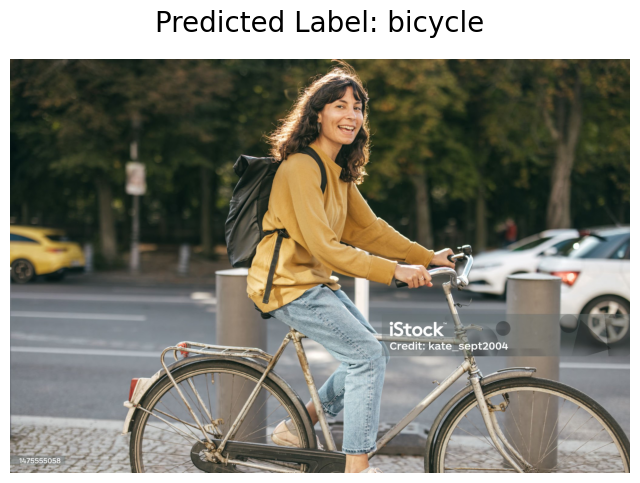

Predicted Label: bicycle


In [14]:
image_path = "/content/drive/MyDrive/Projects/Brose_Vision_Transformer/images/test_images/test_7.jpg"

predicted_label = predict_image(image_path, trained_model)
print(f"Predicted Label: {predicted_label}")